# Fully-saturated TWFE

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

rng = np.random.default_rng(42)

In [3]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## 階層ベイズモデル 不均一分散

$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \beta_{gl} \cdot T_{i} \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta} \sim N(0, 0.3^2)$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2 \sim N^+(0.3^2)$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2 \sim N^+(0.24^2)$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

推定方法に関するメモ

`beta[bridge_year, time_since_treatment]` は不要な経過年数まで推定してしまう．
したがって，`beta_2000[time_since_treatment]`にしようかな．
それだと目的に合ってないか．

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


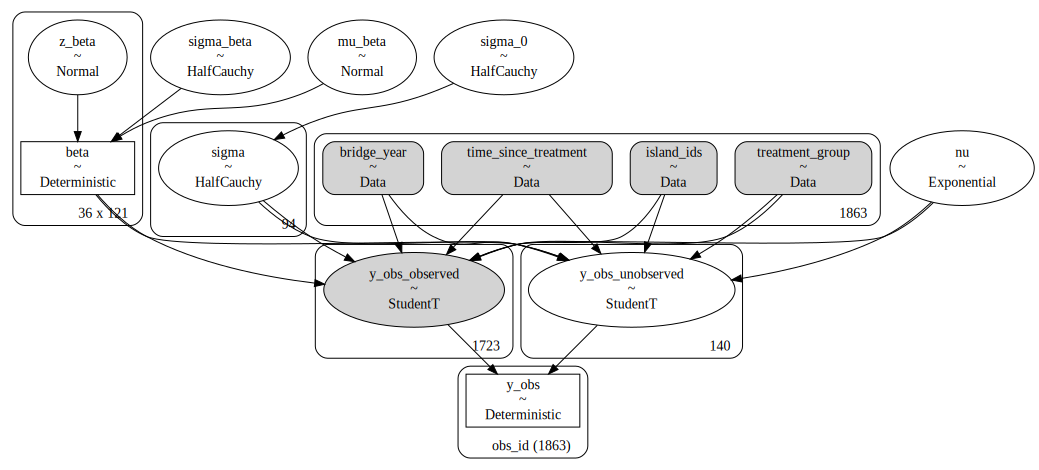

In [4]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
bridge_year, unique_bridge_year = pd.factorize(df['bridge_year'])
n_bridge_year = len(unique_bridge_year)
time_since_treatment, unique_time_since_intervention = pd.factorize(df['time_since_treatment'])
n_time_since_intervention = len(unique_time_since_intervention)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.3)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=0.3)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, shape=(n_bridge_year, n_time_since_intervention))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta)

    # sigma
    sigma_0 = pm.HalfNormal('sigma_0', sigma=0.24)
    sigma = pm.HalfNormal('sigma', sigma=sigma_0, shape=n_islands)

    # nu
    nu = pm.Exponential('nu', lam=1/10)

    # expected value
    mu = beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_ids], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [5]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2000,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=rng
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
az.summary(trace_h_hetero, var_names=['mu_beta', 'sigma_beta', 'sigma_0', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,-0.031,0.008,-0.048,-0.015,0.000,0.000,406.0,986.0,1.02
sigma_beta,0.124,0.007,0.111,0.138,0.000,0.000,311.0,882.0,1.02
sigma_0,0.139,0.019,0.102,0.174,0.000,0.000,1512.0,996.0,1.00
nu,6.786,1.491,4.453,9.622,0.032,0.022,1796.0,3876.0,1.00


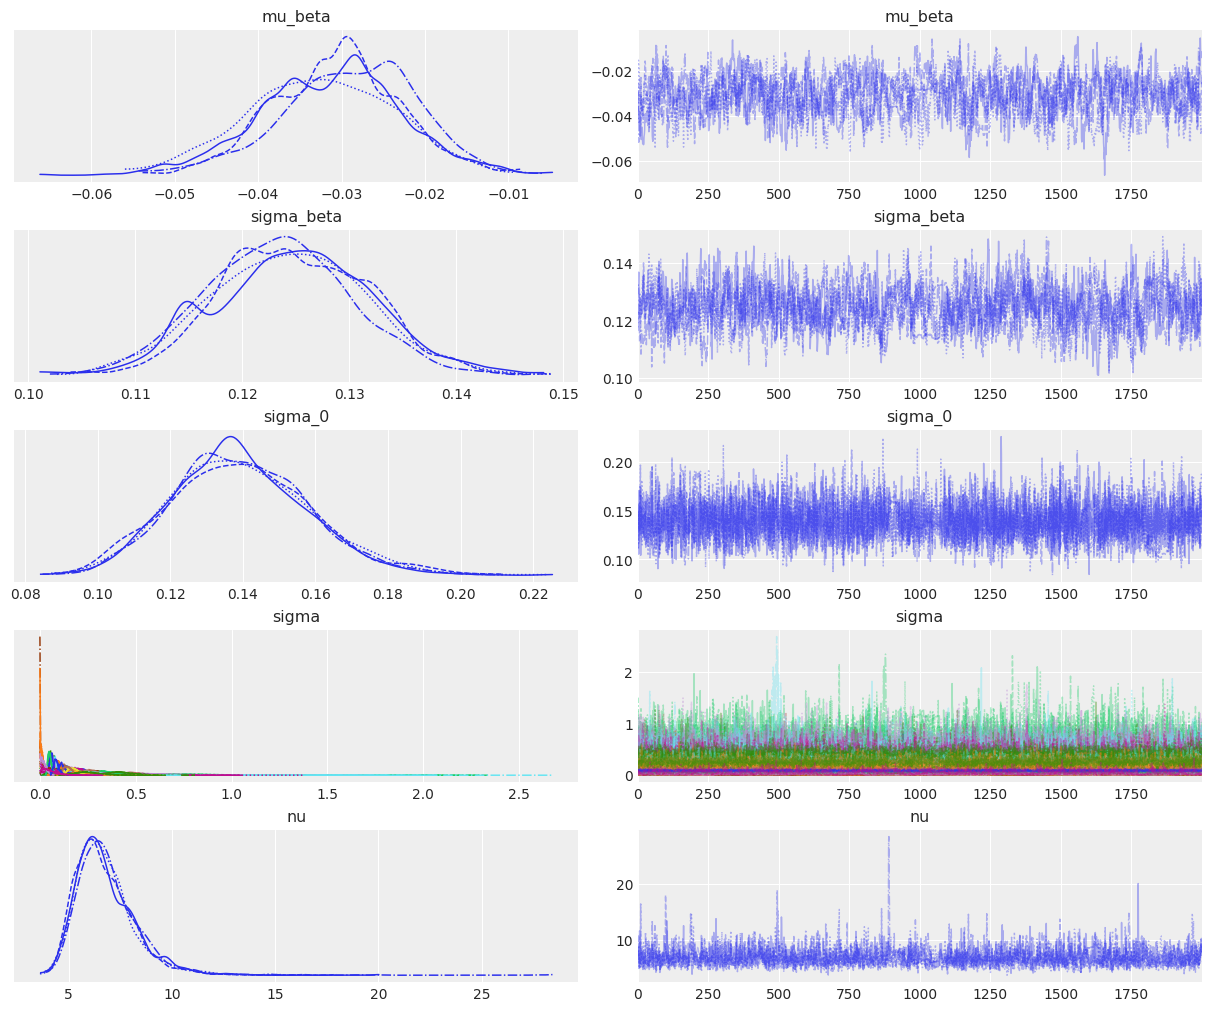

In [5]:
az.plot_trace(trace_h_hetero, var_names=['mu_beta', 'sigma_beta', 'sigma_0', 'sigma', 'nu']);

In [73]:
beta_df = pd.read_csv('beta_hetero_df.csv')

betaのr-hatは最大で1.07だったのでまあ良いでしょう．

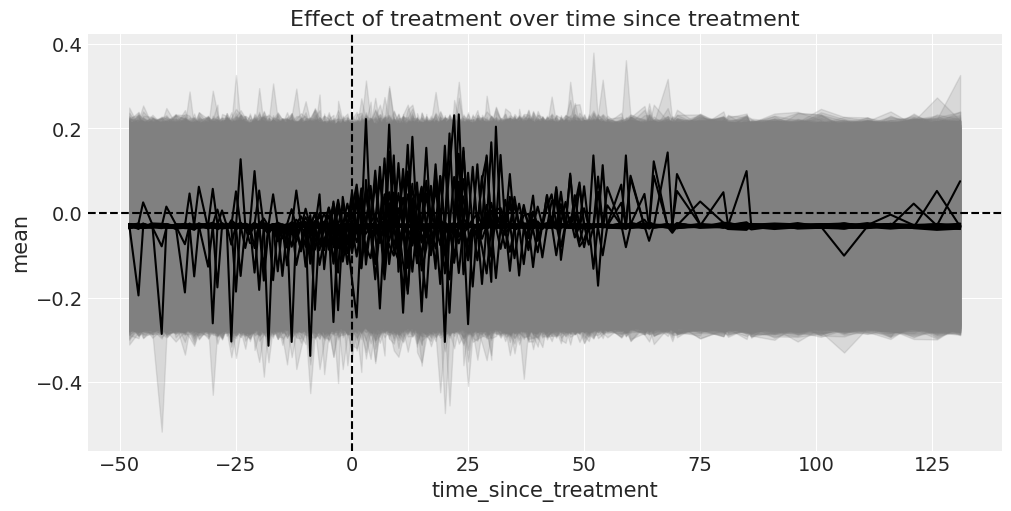

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))
for bridge_year in df['bridge_year'].unique():
    beta_g = beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
    sns.lineplot(x='time_since_treatment', y='mean', data=beta_g, color='black', ax=ax)
    ax.fill_between(beta_g['time_since_treatment'], beta_g['hdi_2.5%'], beta_g['hdi_97.5%'], alpha=0.2, color='gray')
    ax.set_title(f'Effect of treatment over time since treatment')
ax.axvline(0, color='black', linestyle='--')
ax.axhline(0, color='black', linestyle='--')
plt.show()

## 階層ベイズモデル 均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


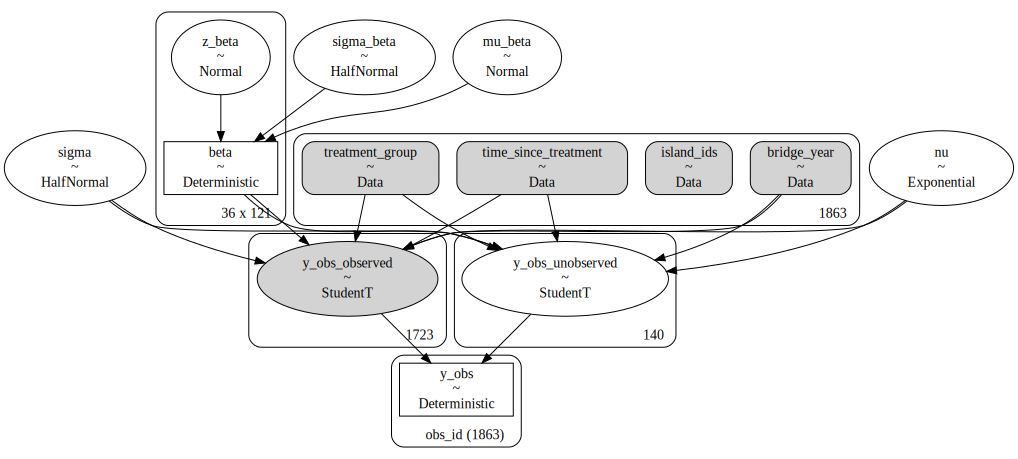

In [4]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
bridge_year, unique_bridge_year = pd.factorize(df['bridge_year'])
n_bridge_year = len(unique_bridge_year)
time_since_treatment, unique_time_since_intervention = pd.factorize(df['time_since_treatment'])
n_time_since_intervention = len(unique_time_since_intervention)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h_homo:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.3)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=0.3)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, shape=(n_bridge_year, n_time_since_intervention))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta)

    # sigma
    sigma = pm.HalfNormal('sigma', sigma=0.24) # log_pop_star の標準偏差

    # nu
    nu = pm.Exponential('nu', lam=1/10)

    # expected value
    mu = beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_homo)

In [5]:
with model_h_homo:
    trace_h_homo = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
az.summary(trace_h_homo, var_names=['mu_beta', 'sigma_beta', 'nu', 'sigma'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,-0.046,0.009,-0.062,-0.028,0.000,0.000,3162.0,2796.0,1.0
sigma_beta,0.111,0.011,0.090,0.131,0.000,0.000,1080.0,1730.0,1.0
nu,2.442,0.193,2.092,2.840,0.004,0.003,1968.0,2417.0,1.0
sigma,0.127,0.005,0.116,0.136,0.000,0.000,1691.0,2771.0,1.0


In [1]:
az.plot_trace(trace_h_homo, var_names=['mu_beta', 'sigma_beta', 'nu', 'sigma'])

NameError: name 'az' is not defined

## サンプリングの保存

In [6]:
# az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/trace_h_hetero.nc')
az.to_netcdf(trace_h_homo, './mcmc_sample/fully_saturated/trace_h_homo.nc')

'./mcmc_sample/fully_saturated/trace_h_hetero.nc'

In [3]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/trace_h_hetero.nc')